In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import math
import torchvision.models as models
from PIL import Image
from deepfool import deepfool
import os

In [2]:
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ['CUDA_VISIBLE_DEVICES']='1'
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
net = models.resnet34(pretrained=True)

# Switch to evaluation mode
net.eval()

im_orig = Image.open('test_im2.jpg')

mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]


# Remove the mean
im = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean,
                         std = std)])(im_orig)

/home/nikhil/tflow/local/lib/python2.7/site-packages/torchvision/transforms/transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [4]:
r, loop_i, label_orig, label_pert, pert_image = deepfool(im, net)

Using GPU


In [5]:
labels = open(os.path.join('synset_words.txt'), 'r').read().split('\n')

str_label_orig = labels[np.int(label_orig)].split(',')[0]
str_label_pert = labels[np.int(label_pert)].split(',')[0]

print("Original label = ", str_label_orig)
print("Perturbed label = ", str_label_pert)

def clip_tensor(A, minv, maxv):
    A = torch.max(A, minv*torch.ones(A.shape))
    A = torch.min(A, maxv*torch.ones(A.shape))
    return A

clip = lambda x: clip_tensor(x, 0, 255)

tf = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=map(lambda x: 1 / x, std)),
                        transforms.Normalize(mean=map(lambda x: -x, mean), std=[1, 1, 1]),
                        transforms.Lambda(clip),
                        transforms.ToPILImage(),
                        transforms.CenterCrop(224)])

('Original label = ', 'n03538406 horse cart')
('Perturbed label = ', 'n02437312 Arabian camel')


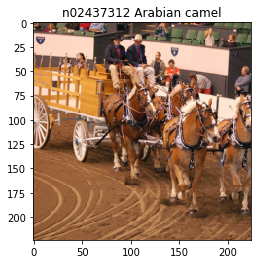

In [6]:
plt.figure()
plt.imshow(tf(pert_image.cpu()[0]))
plt.title(str_label_pert)
plt.show()

In [31]:
image = im
num_classes = 10

In [32]:
# define networks
net1 = models.resnet34(pretrained=True)
net2 = models.resnet34(pretrained=False)
nets = [net1,net2]
# Switch to evaluation mode
for net in nets:
    net.eval()

In [33]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    print("Using GPU")
    image = image.cuda()
    for net in nets:
        net = net.cuda()
else:
    print("Using CPU")

Using GPU


In [34]:
f_images = []
# TODO: predict class by majority vote
for net in nets:
    f_image = net.forward(Variable(image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
    f_images.append(np.array(f_image))
f_images = np.array(f_images)
# take the prediction to be the average of predictions of each of the nets
f_image_mean = np.mean(f_images,axis=0)
I = f_image_mean.flatten().argsort()[::-1]

/home/nikhil/tflow/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
I = I[0:num_classes]
label = I[0]

input_shape = image.cpu().numpy().shape
pert_image = copy.deepcopy(image)
w = np.zeros(input_shape)
r_tot = np.zeros(input_shape)

loop_i = 0
x = Variable(pert_image[None, :], requires_grad=True)
fs = net.forward(x)
fs_list = [fs[0,I[k]] for k in range(num_classes)]
k_i = label

while k_i == label and loop_i < max_iter:

    pert = np.inf
    fs[0, I[0]].backward(retain_graph=True)
    grad_orig = x.grad.data.cpu().numpy().copy()

    for k in range(1, num_classes):
        zero_gradients(x)

        fs[0, I[k]].backward(retain_graph=True)
        cur_grad = x.grad.data.cpu().numpy().copy()

        # set new w_k and new f_k
        w_k = cur_grad - grad_orig
        f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

        pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

        # determine which w_k to use
        if pert_k < pert:
            pert = pert_k
            w = w_k

    # compute r_i and r_tot
    # Added 1e-4 for numerical stability
    r_i =  (pert+1e-4) * w / np.linalg.norm(w)
    r_tot = np.float32(r_tot + r_i)

    if is_cuda:
        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).cuda()
    else:
        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

    x = Variable(pert_image, requires_grad=True)
    fs = net.forward(x)
    k_i = np.argmax(fs.data.cpu().numpy().flatten())

    loop_i += 1

r_tot = (1+overshoot)*r_tot

return r_tot, loop_i, label, k_i, pert_image